# Problema a tratar


**Generar una mama realista a partir de un dibujo simple para encontrar una solución al problema de imágenes en medicina**

Es complicado acceder a la información por imágenes médicas debido a las políticas de confidencialidad de los pacientes, lo cual, es claramente aceptable pero restringe la transmisión de conocimientos más allá de los resultados. Para fines investigativos en los que los resultados sean publicables, entrenar la red Pix2pix es una excelente alternativa para generar material educativo o imágenes que sirvan como data de entrenamiento para otros tipos de redes o problemas específicos.

**Obtener un dibujo simple que represente las características mas importantes de la mama a partir de un estudio clínico**

Las imágenes en mamografía se tornan complicadas en su análisis ya que sus estructuras son difíciles de segmentar; esto hace que la sustracción de características sea tediosa si no se cuenta con herramientas de mayos complejidad. El uso de la Pix2pix permite automatizar el proceso de diferenciación de estructuras individuales para trabajar con este tipo de imágenes médicas.

# 2. Cargar Dataset

In [ ]:
# Clonamos el repositorio de GitHub
!git clone https://github.com/mandalarotation/Concurso_dotcsv_Proyecto_Mamografias.git

# Definimos las rutas a las carpetas de datos
PATH = "/content/Concurso_dotcsv_Proyecto_Mamografias/Dataset/"
INPATH = PATH + "A"
OUPATH = PATH + "B"
CKPATH = PATH + "checkpoints"



Cloning into 'Concurso_dotcsv_Proyecto_Mamografias'...
remote: Enumerating objects: 3804, done.
remote: Total 3804 (delta 0), reused 0 (delta 0), pack-reused 3804 (from 1)
Receiving objects: 100% (3804/3804), 119.29 MiB | 15.44 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Updating files: 100% (3691/3691), done.


# 3. Importar Librerías

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# 4. Preprocesamiento

## Leer aleatoreamente y particionar datos

In [ ]:
# Obtenemos una lista de los nombres de los archivos de imágenes en la carpeta de entrada y la ordenamos alfabéticamente.
imgurls = sorted(os.listdir(INPATH))

# Calculamos el número total de imágenes disponibles.
n = len(imgurls)

# Definimos el número de imágenes para entrenamiento como el 80% del total.
train_n = round(n * 0.80)

# Hacemos una copia aleatorizada de los nombres de las imágenes para crear las particiones de train y test.
randurls = np.copy(imgurls)
np.random.shuffle(randurls)

# Particionamos las rutas en conjunto de entrenamiento (80%) y conjunto de prueba (20%).
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:]

# Imprimimos la cantidad total de imágenes, así como la cantidad de imágenes en cada partición.
print(len(imgurls), len(tr_urls), len(ts_urls))


523 418 105


## Reescalar imagen

In [ ]:
# Definimos el ancho y alto de las imágenes a 256 píxeles, que serán las dimensiones finales tras el preprocesamiento.
IMG_WIDTH = 256
IMG_HEIGHT = 256


In [ ]:
# Reescalar imagenes

# Función para redimensionar las imágenes de entrada y objetivo a las dimensiones especificadas.
def resize(inimg, tgimg, heigth, width):
  # Cambia el tamaño de la imagen de entrada (inimg) y de la imagen objetivo (tgimg) al alto y ancho dados.
  inimg = tf.image.resize(inimg, [heigth, width])
  tgimg = tf.image.resize(tgimg, [heigth, width])

  # Devuelve las imágenes redimensionadas.
  return inimg, tgimg

Esta función permite que las imágenes de entrada y objetivo tengan dimensiones consistentes antes de realizar otros pasos de preprocesamiento.

## Función para Normalizar Imágenes


In [ ]:
# Normaliza las imágenes de entrada y objetivo al rango [-1, 1].
def normalize(inimg, tgimg):
  # Convierte los valores de píxeles de [0, 255] a [-1, 1].
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  # Devuelve las imágenes normalizadas.
  return inimg, tgimg

Al normalizar las imágenes al rango [-1, 1], se facilita el entrenamiento de la red neuronal, ya que las redes neuronales generalmente convergen mejor con valores en rangos estándar.

## Función para Aumento de Datos (Data Augmentation)

In [ ]:
# Aplica aumento de datos a las imágenes, utilizando recorte aleatorio y volteo horizontal.
def random_jitter(inimg, tgimg):
  # Redimensiona las imágenes de entrada y objetivo a 286x286 píxeles como paso previo.
  #inimg, tgimg = resize(inimg, tgimg, 286, 286)

  # Apila las imágenes de entrada y objetivo en una sola estructura, a lo largo de un nuevo eje.
  #stacked_image = tf.stack([inimg, tgimg], axis=0)

  # Recorta aleatoriamente un área de 256x256 de las imágenes apiladas, lo que aplica recorte simultáneamente a ambas.
  #cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  # Separa la imagen de entrada y la imagen objetivo del tensor recortado.
  #inimg, tgimg = cropped_image[0], cropped_image[1]

  # Realiza un volteo horizontal con probabilidad del 50%.
  if np.random.rand() > 0.5:
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  # Devuelve las imágenes aumentadas.
  return inimg, tgimg





* Este proceso de aumento de datos ayuda a hacer que el modelo sea más robusto al aumentar la variabilidad de las imágenes de entrenamiento.
* Primero, las imágenes se redimensionan a un tamaño mayor (286x286 píxeles), luego se recortan aleatoriamente a 256x256, lo que permite que el modelo vea diferentes partes de la imagen.

* El volteo horizontal introduce aún más variación.



# 5. División Train/Test y Carga de Datos

## Cargar imagenes

In [ ]:
#Funcion para cargar las imagenes

# Función para cargar las imágenes de entrada y objetivo
def load_image(filename, augment=True):
  # Leer y decodificar la imagen de entrada desde el archivo
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3]

  # Leer y decodificar la imagen objetivo desde el archivo
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)), tf.float32)[..., :3]

  # Redimensionar las imágenes al tamaño especificado
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  # Aplicar aumento de datos si se especifica
  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)

  # Normalizar las imágenes al rango [-1, +1]
  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg

# Función para cargar una imagen de entrenamiento con aumento
def load_train_image(filename):
  return load_image(filename, True)

# Función para cargar una imagen de prueba sin aumento
def load_test_image(filename):
  return load_image(filename, False)



Decodificación y tipo de datos: Se utiliza tf.image.decode_jpeg para leer las imágenes en formato JPEG y luego tf.cast para convertirlas a tipo tf.float32. El índice [..., :3] asegura que solo se mantengan los tres primeros canales (RGB), descartando otros canales si están presentes.

Redimensionamiento: Llama a la función resize para ajustar las dimensiones de ambas imágenes de acuerdo al tamaño esperado por la red.

Aumento de datos opcional: augment=True permite la opción de aplicar o no el aumento de datos, lo que es útil para distinguir entre el conjunto de entrenamiento y el conjunto de prueba.

Normalización: Finalmente, normaliza las imágenes, un paso importante para que los datos estén en el rango correcto para el modelo y evitar saturaciones en las activaciones de la red.

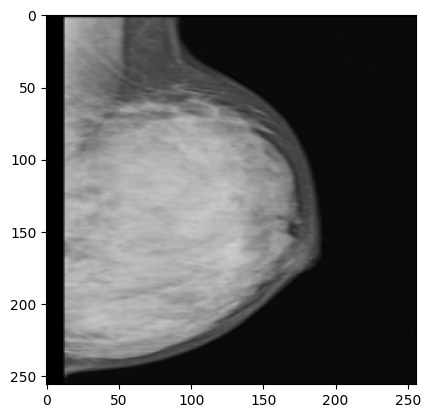

In [ ]:
plt.imshow((load_train_image(randurls[0])[0]+1)/2)

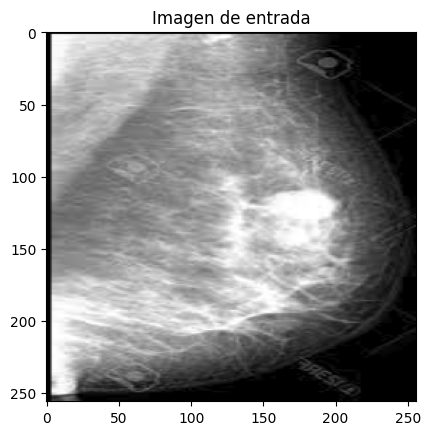

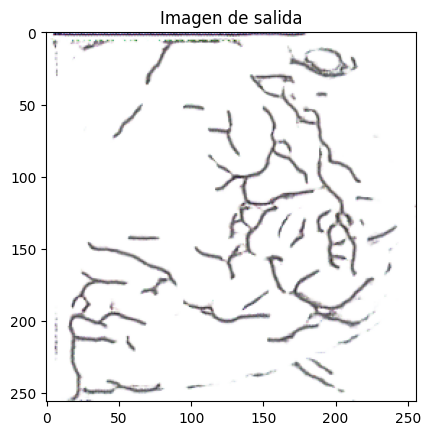

In [ ]:
import random

# Selecciona un índice aleatorio de la lista de imágenes
random_index = random.randint(0, len(randurls) - 1)

# Carga la imagen usando la función load_train_image
input_image, target_image = load_train_image(randurls[random_index])

# Muestra la imagen de entrada
plt.imshow((input_image + 1) / 2)  # Desnormaliza la imagen para mostrarla correctamente
plt.title("Imagen de entrada")
plt.show()

# (Opcional) Muestra la imagen de salida (target_image) también
plt.imshow((target_image + 1) / 2)
plt.title("Imagen de salida")
plt.show()

Selección aleatoria de imágenes: random.randint(0, len(randurls) - 1) selecciona un índice aleatorio de randurls para visualizar una imagen aleatoria de entrada y su imagen objetivo correspondiente.

Visualización: La desnormalización con (input_image + 1) / 2 asegura que la imagen se muestra correctamente en el rango de visualización de Matplotlib. La misma técnica se aplica para mostrar la imagen de salida (target_image), permitiendo comprobar la correspondencia de entrada y salida visualmente.

## Div train and test

In [ ]:
# Creación del dataset de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

# Creación del dataset de prueba
test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)


**Dataset de entrenamiento:** train_dataset se genera a partir de tr_urls usando tf.data.Dataset.from_tensor_slices. Cada elemento se pasa a load_train_image usando map, aplicando el preprocesamiento de imagen y el aumento de datos. num_parallel_calls=tf.data.experimental.AUTOTUNE permite paralelizar la carga de datos para mejorar el rendimiento. La función batch(1) organiza el dataset en lotes de tamaño 1, como lo requiere la red.

**Dataset de prueba:** test_dataset se configura de manera similar pero llama a load_test_image, lo que evita el aumento de datos para las imágenes de prueba. Esto asegura la consistencia durante la evaluación.

# 6. Red Neuronal - Downsample y Upsample

Incluye las funciones downsample y upsample

In [ ]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):

  result = Sequential()

  initializer = tf.random_normal_initializer(0,0.02)

  #capa convolucional

  result.add(Conv2D(filters,
                    kernel_size = 4,
                    strides = 2,
                    padding = "same",
                    kernel_initializer = initializer,
                    use_bias = not apply_batchnorm))

  # Capa de batch normalization

  if apply_batchnorm:
    result.add(BatchNormalization())

  #Capa de activacion (leak relu)

  result.add(ReLU())

  return result

downsample(64)


<Sequential name=sequential, built=False>

In [ ]:
def upsample(filters, apply_dropout=False):

  result = Sequential()

  initializer = tf.random_normal_initializer(0,0.02)

  #capa convolucional

  result.add(Conv2DTranspose(filters,
                             kernel_size = 4,
                             strides = 2,
                             padding = "same",
                             kernel_initializer = initializer,
                             use_bias = False))

  # Capa de batch normalization
  result.add(BatchNormalization())

  if apply_dropout:
    result.add(Dropout(0.5))


  #Capa de activacion (leak relu)
  result.add(ReLU())

  return result

upsample(64)



<Sequential name=sequential_1, built=False>

# 7. Generador

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[None,None,3])

  down_stack = [
    downsample(64, apply_batchnorm=False),
    downsample(128),
    downsample(256),
    downsample(512),
    downsample(512),
    downsample(512),
    downsample(512),
    downsample(512),
  ]

  up_stack = [
    upsample(512,apply_dropout=True),
    upsample(512,apply_dropout=True),
    upsample(512,apply_dropout=True),
    upsample(512),
    upsample(256),
    upsample(128),
    upsample(64),
  ]

  initializer = tf.random_normal_initializer(0,0.02)

  last = Conv2DTranspose(filters=3,
                         kernel_size = 4,
                         strides = 2,
                         padding = "same",
                         kernel_initializer = initializer,
                         activation = "tanh")


  x = inputs

  s = []

  concat = Concatenate()

  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1])

  for up,sk in zip(up_stack,s):
    x = up(x)
    x = concat([x,sk])

  last = last(x)

  return Model(inputs = inputs, outputs = last)

generator = Generator()

La función `Generator()` define un generador para la arquitectura pix2pix, que utiliza una estructura de red tipo "U-Net" en la que las capas de codificación (downsampling) están conectadas con capas de decodificación (upsampling) mediante conexiones de salto ("skip connections"). Esto permite que el generador mantenga características importantes de la imagen de entrada en la imagen de salida generada, mejorando así la precisión de los detalles en la síntesis de imágenes.

1. **Definición de la entrada:** Se especifica la capa de entrada `Input(shape=[None,None,3])`, lo que permite que el generador trabaje con imágenes de cualquier tamaño y 3 canales (imágenes en color).

2. **Construcción del `down_stack`:** `down_stack` es una lista de bloques `downsample`, que aplican capas de convolución para extraer características y reducir gradualmente la resolución de la imagen:
   - Se agregan 8 capas `downsample`, duplicando el número de filtros en cada nivel.
   - El primer bloque no aplica batch normalization, lo cual es común en el primer nivel de la red para preservar los valores originales de los datos.

3. **Construcción del `up_stack`:** `up_stack` es una lista de bloques `upsample`, que utilizan convoluciones transpuestas para aumentar la resolución de la imagen y reconstruir la imagen a partir de las características extraídas en el `down_stack`.
   - Las tres primeras capas `upsample` incluyen `apply_dropout=True`, lo cual mejora la generalización del modelo al eliminar aleatoriamente activaciones durante el entrenamiento.
   - La cantidad de filtros va disminuyendo hacia las capas finales para refinar los detalles de la imagen generada.

4. **Capa final:** La última capa es una `Conv2DTranspose` con 3 filtros (para los 3 canales de salida) y activación `tanh`, que escala la salida en el rango de `[-1,1]`, alineándose con la normalización de las imágenes de entrada.

5. **Codificación (downsampling):** Se recorre cada capa en `down_stack`, aplicando `down(x)` y añadiendo la salida `x` a una lista de "skip connections" (`s`). Estas conexiones permiten reutilizar características de las primeras capas durante la fase de decodificación.

6. **Decodificación (upsampling):** Con `s` invertido para emparejar el orden del `up_stack`, se recorre cada capa `upsample`, aplicándola a `x`. Luego, `concat([x, sk])` combina la salida `x` de `upsample` con la correspondiente capa de `downsample` (es decir, "skip connection") para que el generador pueda aprovechar características de múltiples resoluciones.

7. **Salida del modelo:** La capa `last` genera la imagen de salida con la misma resolución que la entrada, finalizando la arquitectura del generador.

Finalmente, `generator = Generator()` crea una instancia del generador.

# 8. Discriminador

In [ ]:
def Discriminator():
  ini = Input(shape = [None, None, 3], name = "input_img")
  gen = Input(shape = [None, None, 3], name = "gener_img")

  con = concatenate([ini,gen])
  initializer = tf.random_normal_initializer(0,0.02)

  down1 = downsample(64, apply_batchnorm = False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)


  last = tf.keras.layers.Conv2D(filters = 1,
                           kernel_size = 4,
                           strides = 1,
                           kernel_initializer = initializer,
                           padding = "same")(down4)

  return tf.keras.Model(inputs = [ini,gen],outputs = last)


discriminator = Discriminator()



El discriminador tiene la tarea de diferenciar entre imágenes reales (objetivo) y las imágenes generadas por el generador. Utiliza una arquitectura tipo "PatchGAN", evaluando la imagen en pequeños parches para distinguir detalles a nivel local en lugar de juzgar la imagen en su totalidad.

1. **Entradas:** El discriminador toma dos imágenes de entrada:
   - `ini`: imagen de entrada original.
   - `gen`: imagen generada (salida del generador).
   
2. **Concatenación de entradas:** Se utiliza `concatenate([ini, gen])` para combinar las dos imágenes en un solo tensor a lo largo del último eje. Esto permite que el discriminador compare directamente la imagen generada con la imagen original de entrada.

3. **Capa inicial (down1):** La primera capa `downsample` tiene 64 filtros y `apply_batchnorm=False`, por lo que esta capa aplica solo convolución. Al no incluir batch normalization, conserva la estructura original de los datos en el primer paso.

4. **Capas intermedias (down2, down3, down4):** Estas capas `downsample` incrementan progresivamente el número de filtros (128, 256 y 512, respectivamente) mientras reducen la resolución de la imagen. Estas capas permiten que el discriminador capture patrones y características de diferentes escalas.

5. **Capa final (`last`):** La última capa es una `Conv2D` con un solo filtro y una activación lineal. Genera un mapa que evalúa la autenticidad de pequeños parches en la imagen compuesta, en lugar de producir un único valor de probabilidad para toda la imagen. Los valores en esta capa indican, para cada parche, si ese segmento parece más real o generado.

6. **Definición del modelo:** El modelo toma como entradas las imágenes `ini` y `gen` y genera el mapa de autenticidad de los parches como salida.


Finalmente, `discriminator = Discriminator()` instancia el discriminador, permitiendo que el modelo esté listo para ser entrenado.


# imagen de entrada y discriminador

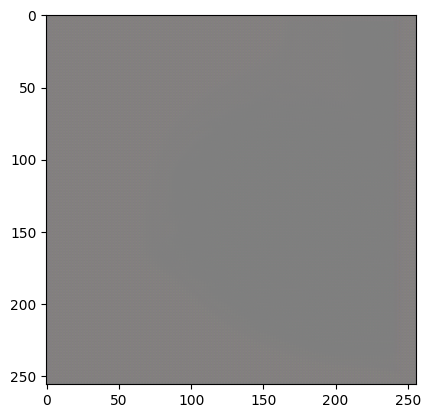

In [ ]:
# Seleccionar una imagen de entrada (inimg) y su imagen objetivo (tgimg) del conjunto de entrenamiento.
# En este caso, solo estamos tomando un lote (un par de imágenes) para hacer una visualización rápida.
for inimg, tgimg in train_dataset.take(1):
    w1 = inimg  # Asigna la imagen de entrada (inimg) a la variable w1 para usarla en el generador.

# Generar una imagen de salida a partir de la imagen de entrada utilizando el generador.
# Ponemos training=False porque solo estamos haciendo una predicción, no entrenando el modelo.
gen_output = generator(w1, training=False)

# Visualizar la imagen generada por el generador.
# (gen_output[0, ...] + 1) / 2 se utiliza para escalar los valores de la imagen de salida
# del rango [-1, 1] (que es la normalización usada en la red) al rango [0, 1], adecuado para visualización.
plt.imshow((gen_output[0, ...] + 1) / 2)


TensorShape([1, 16, 16, 1])

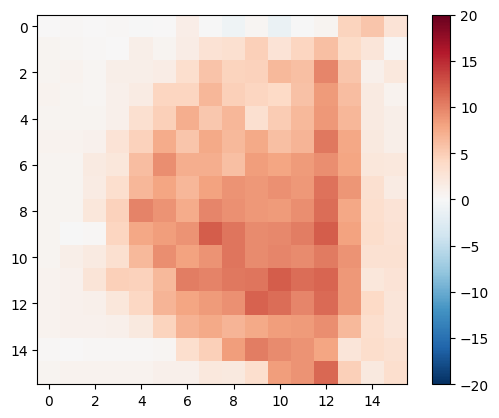

In [ ]:
# Pasa un par de imágenes (la imagen de entrada y la imagen generada) al discriminador.
# ((inimg+1)*255) convierte la imagen de entrada `inimg` del rango [-1, 1] al rango [0, 255].
# Esto es necesario para que coincida con el rango de valores de la imagen generada `gen_output`.
# Se pone training=False porque estamos haciendo una predicción (no entrenamiento) con el discriminador.
disc_out = discriminator([((inimg + 1) * 255), gen_output], training=False)

# Muestra la salida del discriminador en una imagen.
# disc_out[0, ..., -1] selecciona la primera (y única) imagen en el lote, todas las dimensiones
# espaciales (altura y ancho), y el último canal de la salida (para visualizar como imagen).
# vmin y vmax establecen el rango de colores de la visualización para ver mejor los valores,
# y cmap="RdBu_r" establece una paleta de colores de rojo a azul.
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap="RdBu_r")
plt.colorbar()  # Agrega una barra de color para interpretar los valores de la visualización.

# Muestra la forma (dimensiones) de la salida del discriminador, lo cual es útil para depuración
# y para entender cómo se estructuran las predicciones del discriminador.
disc_out.shape


# Funciones de coste adversarias

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(disc_real_output,disc_generated_output):

  #Diferencia entre los true por ser real y el detectado por el discriminador

  real_loss = loss_object(tf.ones_like(disc_real_output),disc_real_output)

  #Diferencia entre los false por ser generado y el detectado por el discriminador

  generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)

  total_dics_loss = real_loss + generated_loss

  return total_dics_loss

1. **Función de pérdida `loss_object`:** Se define `loss_object` usando `tf.keras.losses.BinaryCrossentropy(from_logits=True)`, lo cual permite usar entropía cruzada binaria. La opción `from_logits=True` permite que la función de pérdida tome directamente los valores de salida del discriminador sin necesidad de pasarlos por una función de activación adicional (como sigmoid).

2. **Cálculo de `real_loss`:**
   - `real_loss` mide la diferencia entre las predicciones del discriminador para las imágenes reales (`disc_real_output`) y la etiqueta deseada (`tf.ones_like(disc_real_output)`), que es 1 para todas las posiciones, indicando "verdadero".
   - Cuanto más se acerque el discriminador a predecir 1 para imágenes reales, menor será este valor.

3. **Cálculo de `generated_loss`:**
   - `generated_loss` mide la diferencia entre las predicciones del discriminador para las imágenes generadas (`disc_generated_output`) y la etiqueta `tf.zeros_like(disc_generated_output)`, que es 0, indicando "falso".
   - Cuanto más se acerque el discriminador a predecir 0 para imágenes generadas, menor será este valor.

4. **Cálculo de `total_disc_loss`:** La pérdida total del discriminador es la suma de `real_loss` y `generated_loss`, penalizando tanto los errores al identificar imágenes reales como los errores al identificar imágenes generadas.

5. **Retorno de la pérdida total:** La función retorna `total_disc_loss`, que representa cuán bien está el discriminador diferenciando entre imágenes reales y generadas. Durante el entrenamiento, se busca minimizar esta pérdida para mejorar la precisión del discriminador.

In [ ]:
LAMBDA = 100  # Peso del error L1 (MAE) en la pérdida total del generador

def generator_loss(disc_generated_output, gen_output, target):
  """
  Calcula la pérdida total del generador en la red Pix2Pix GAN.

  Args:
    disc_generated_output: Salida del discriminador para la imagen generada.
    gen_output: Salida del generador (imagen generada).
    target: Imagen objetivo (ground truth).

  Returns:
    total_gen_loss: Pérdida total del generador.
  """

  # Pérdida adversarial: Se compara la salida del discriminador para la imagen
  # generada con la etiqueta 'real' (1), utilizando la función de pérdida
  # `loss_object` (definida previamente como entropía cruzada binaria).
  gen_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Pérdida L1 (Mean Absolute Error - MAE): Se calcula la diferencia absoluta
  # promedio entre la imagen generada (`gen_output`) y la imagen objetivo (`target`).
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  # Pérdida total del generador: Se combina la pérdida adversarial y la pérdida L1,
  # ponderando la pérdida L1 con el factor `LAMBDA`.
  total_gen_loss = gen_loss + (LAMBDA * l1_loss)

  # Se retorna la pérdida total del generador.
  return total_gen_loss

In [ ]:
import os

# Define el optimizador para el generador.
# Se usa el optimizador Adam con una tasa de aprendizaje de 2e-4 y beta_1=0.5,
# lo cual ayuda a estabilizar el entrenamiento de redes GAN al reducir la varianza en los gradientes.
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define el optimizador para el discriminador, utilizando los mismos parámetros que el generador.
# Esto es común en redes GAN, ya que ambos modelos deben ajustarse a tasas de aprendizaje similares.
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define una ruta para guardar los checkpoints (puntos de control) durante el entrenamiento.
# CKPATH es la ruta base, y "ckpt" se añade como prefijo para los archivos de checkpoint.
checkpoint_prefix = os.path.join(CKPATH, "ckpt")

# Crea un objeto checkpoint de TensorFlow para almacenar y restaurar el estado del modelo y los optimizadores.
# Especifica los elementos a guardar, en este caso:
# - `generator_optimizer`: los parámetros del optimizador del generador.
# - `discriminator_optimizer`: los parámetros del optimizador del discriminador.
# - `generator`: el modelo del generador.
# - `discriminator`: el modelo del discriminador.
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)


#restaurar ultimo checkpoint

#checkpoint.restore(tf.train.latest_checkpoint(CKPATH).assert_consumed())

# Evaluar Entrenamiento

In [ ]:
# Evaluar el comportamiento a medida que la red entrena

# Función para generar y visualizar imágenes durante el entrenamiento.
# Esta función se utiliza para observar cómo el modelo (generador) produce imágenes a medida que el entrenamiento progresa.
# También permite guardar la imagen generada en disco si se proporciona un nombre de archivo.

def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
    # Genera una predicción utilizando el modelo generador con el test_input.
    # `training=True` indica que se mantiene el mismo comportamiento que durante el entrenamiento (como Dropout).
    prediction = model(test_input, training=True)

    # Si se ha especificado `save_filename`, guarda la imagen generada en la carpeta indicada.
    if save_filename:
        tf.keras.preprocessing.image.save_img(PATH + "outputs_BtoA/" + save_filename + ".jpg", prediction[0, ...])

    # Configura una figura de 10x10 para visualizar las imágenes.
    plt.figure(figsize=(10,10))

    # Lista de imágenes a mostrar: imagen de entrada, imagen objetivo (ground truth), y la imagen predicha por el modelo.
    display_list = [test_input[0], tar[0], prediction[0]]

    # Títulos para cada una de las imágenes.
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    # Si `display_imgs` es True, muestra las imágenes.
    if display_imgs:
        for i in range(3):
            plt.subplot(1, 3, i + 1)          # Crea un subgráfico para cada imagen.
            plt.title(title[i])               # Asigna un título.
            # Ajusta los valores de los píxeles al rango [0, 1] para visualización.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis("off")                   # Quita los ejes para una visualización más limpia.

    # Muestra la figura con las tres imágenes (entrada, objetivo, y predicción).
    plt.show()



# Entrenamiento

In [ ]:
# Decorador `@tf.function` para optimizar el rendimiento de la función en TensorFlow.

def train_step(input_image, target):
    # `tf.GradientTape` permite calcular los gradientes de pérdida para actualizar el modelo.
    # Utilizamos dos cintas de gradiente: una para el generador (gen_tape) y otra para el discriminador (discr_tape).
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

        # Genera una imagen de salida usando el generador con la imagen de entrada como input.
        output_image = generator(input_image, training=True)

        # Calcula la salida del discriminador para la imagen generada (fake) junto con la imagen de entrada.
        # Esto permite al discriminador evaluar si la imagen generada es real o falsa.
        output_gen_discr = discriminator([output_image, input_image], training=True)

        # Calcula la salida del discriminador para la imagen objetivo (real) junto con la imagen de entrada.
        # Esto permite al discriminador distinguir entre la imagen real y la generada.
        output_trg_discr = discriminator([target, input_image], training=True)

        # Calcula la pérdida del discriminador comparando su salida para las imágenes reales y generadas.
        discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

        # Calcula la pérdida del generador comparando la imagen generada y la imagen real, y también cómo el
        # discriminador califica la imagen generada.
        gen_loss = generator_loss(output_gen_discr, output_image, target)

        # Calcula los gradientes de la pérdida del generador respecto a las variables entrenables del generador.
        generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

        # Calcula los gradientes de la pérdida del discriminador respecto a las variables entrenables del discriminador.
        discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

        # Aplica los gradientes al optimizador del generador para actualizar sus variables entrenables.
        generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

        # Aplica los gradientes al optimizador del discriminador para actualizar sus variables entrenables.
        discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

        print("Generator loss:", gen_loss.numpy())
        print("Discriminator loss:", discr_loss.numpy())

        # Return the loss values
        return gen_loss, discr_loss


In [ ]:
#Rutina de entrenamiento

# Importamos clear_output para limpiar la salida entre pasos de entrenamiento y hacer el seguimiento más legible.
from IPython.display import clear_output

gen_losses = []
discr_losses = []



# Definimos la función de entrenamiento `train` que toma el dataset y el número de épocas como argumentos.
def train(dataset, epochs):
    # Iteramos sobre cada época.
    for epoch in range(epochs):
        imgi = 0  # Contador para el número de imágenes en cada época.

        # Entrenamiento en el conjunto de datos.
        for input_image, target in dataset:
            # Mostramos el progreso en la consola.
            print("epoch " + str(epoch) + " - train: " + str(imgi) + "/" + str(len(tr_urls)))
            imgi += 1

            # Llamamos a `train_step` para realizar un paso de entrenamiento con la imagen de entrada y su objetivo.
            # and get the losses returned
            gen_loss, discr_loss = train_step(input_image, target)

            # Limpiamos la salida para mostrar solo la información relevante actual en cada paso.
            #clear_output(wait=False)

            # Store the loss values
            gen_losses.append(gen_loss.numpy())
            discr_losses.append(discr_loss.numpy())


        # Reiniciamos el contador para las imágenes de prueba.
        imgi = 0

        # Generación de imágenes para el conjunto de prueba para verificar el progreso del modelo.
        # Tomamos 5 muestras del conjunto de prueba y generamos imágenes de salida.

        clear_output(wait=False)


        for inp, tar in test_dataset.take(5):
            # Llamamos a `generate_images` para mostrar la imagen de entrada, la real y la generada.
            # Guardamos la imagen generada con un nombre que incluye el índice y la época actual.
            generate_images(generator, inp, tar, str(imgi) + "_" + str(epoch), display_imgs=True)
            imgi += 1

        # Guardamos un punto de control (checkpoint) cada 20 épocas para preservar el estado del modelo.
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Plot the loss values after training
        plt.plot(gen_losses, label="Generator loss")
        plt.plot(discr_losses, label="Discriminator loss")
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


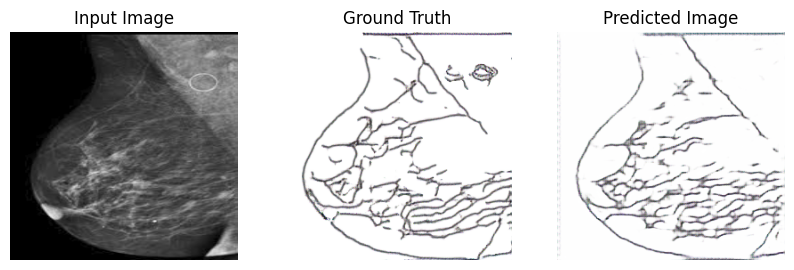

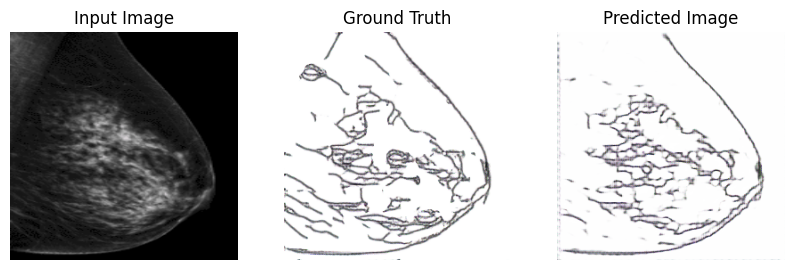

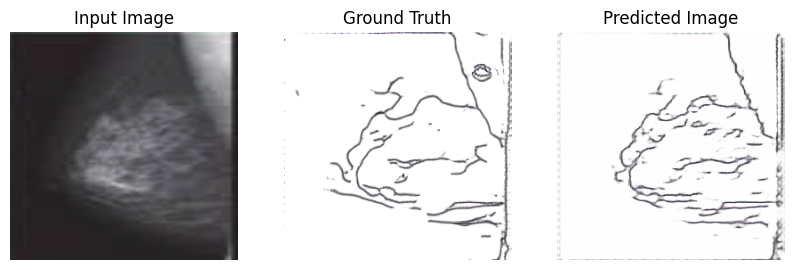

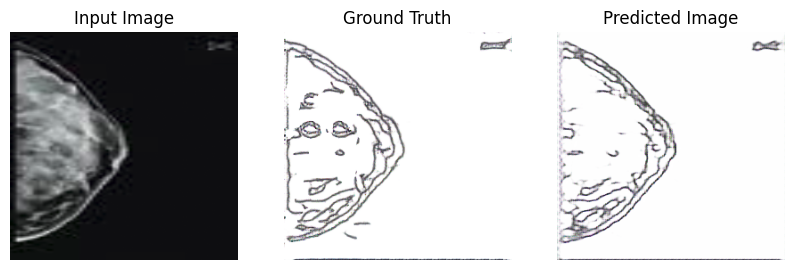

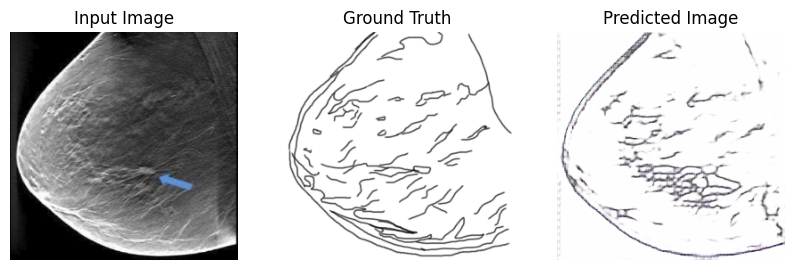

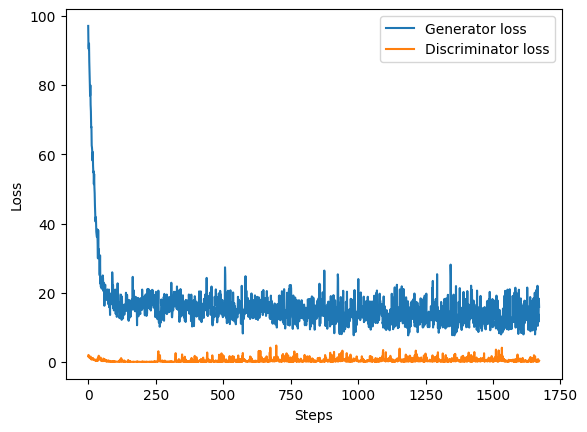

epoch 4 - train: 0/418
Generator loss: 9.057533
Discriminator loss: 0.9965366
epoch 4 - train: 1/418
Generator loss: 9.978728
Discriminator loss: 1.2187114
epoch 4 - train: 2/418
Generator loss: 12.7176075
Discriminator loss: 0.94793534
epoch 4 - train: 3/418
Generator loss: 9.051408
Discriminator loss: 0.33137763
epoch 4 - train: 4/418
Generator loss: 8.996479
Discriminator loss: 0.40079895
epoch 4 - train: 5/418
Generator loss: 10.199248
Discriminator loss: 0.63549984
epoch 4 - train: 6/418
Generator loss: 15.467375
Discriminator loss: 1.075727
epoch 4 - train: 7/418
Generator loss: 10.3557
Discriminator loss: 0.18415529
epoch 4 - train: 8/418
Generator loss: 9.326039
Discriminator loss: 2.0769074
epoch 4 - train: 9/418
Generator loss: 14.966901
Discriminator loss: 0.104142934
epoch 4 - train: 10/418
Generator loss: 12.380859
Discriminator loss: 0.98934627
epoch 4 - train: 11/418
Generator loss: 11.880413
Discriminator loss: 0.75617504
epoch 4 - train: 12/418
Generator loss: 11.20254

In [ ]:
train(train_dataset,70)

In [ ]:
# Plot the loss values after training
plt.plot(gen_losses, label="Generator loss")
plt.plot(discr_losses, label="Discriminator loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint("/content/drive/My Drive/ConcursoDotCsv/Modelos_Entrenados/model_trained_AtoB/checkpoints"))

In [ ]:
for inp, tar in test_dataset.take(15):
  generate_images(generator, inp, tar)

# Referencias
[DOTCSV: Generando FLORES realistas con IA - Pix2Pix | IA NOTEBOOK #5](https://www.youtube.com/watch?v=YsrMGcgfETY&t=1s)

[Así funciona DeepNUDE, la IA que te desnuda - (cGANs y Pix2Pix)](https://www.youtube.com/watch?v=ysEjAqnHp64)

[Proceso delineación imágenes](https://www.youtube.com/watch?v=-59jc6V7aNs)